In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType, IntegerType 
from pyspark.sql.window import Window

import socket

import pandas as pd

In [2]:
LOCAL_IP = socket.gethostbyname(socket.gethostname())
LOCAL_IP

'10.128.66.159'

In [3]:
spark = (SparkSession
         .builder
         .master('k8s://https://10.32.7.103:6443')
         .config('spark.driver.host', LOCAL_IP)
         .config('spark.driver.bindAddress', '0.0.0.0')
         .config('spark.executor.instances', '2')
         .config('spark.executor.cores', '2')
         .config('spark.cores.max', '4')
         .config('spark.executor.memory', '4g')
         .config('spark.sql.execution.arrow.enabled', 'true')
         .config('spark.kubernetes.namespace', 'dpogrebnoj-338138')
         .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:dpogrebnoj-338138')
         .config('spark.kubernetes.container.image.pullPolicy', 'Always')
         .config('spark.kubernetes.executor.deleteOnTermination', 'false')
         .config('spark.sql.autoBroadcastJoinThreshold', '100k')
         .getOrCreate()
        )

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=k8s://https://10.32.7.103:6443 appName=pyspark-shell>

In [51]:
len([executor.host() for executor in spark._jsc.sc().statusTracker().getExecutorInfos()]) -1 

2

# Task 1 - Find the top 20 posts in the group

In [52]:
df_post_api = spark.read.json("hdfs:///shared/bigdata20/posts_api.json").cache()

In [53]:
df_post_api.printSchema()

root
 |-- attachments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album: struct (nullable = true)
 |    |    |    |-- created: long (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |-- size: long (nullable = true)
 |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |-- access_key: string (nullable = true)
 |    |    |    |    |-- album_id: long (nullable = true)
 |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- height: long (nullable = true)
 |    |    |    |    |    |    |-- type: string (nullable = true)
 |   

## Point a - by likes

In [54]:
post_likes = df_post_api.select(["id", "likes.count"])
post_likes.show(10)

+-----+-----+
|   id|count|
+-----+-----+
|17274|   12|
|17273|    7|
|17313|   14|
|17301|   30|
|17295|   10|
|17293|   51|
|17277|   16|
|17276|    4|
|17326|   68|
|17323|    1|
+-----+-----+
only showing top 10 rows



In [55]:
task_1_a = post_likes.sort(F.col("count").desc())
task_1_a.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_1_a.json")
task_1_a.show(20)

+-----+-----+
|   id|count|
+-----+-----+
|32022| 1637|
|35068| 1629|
|17492| 1516|
|18526| 1026|
|19552|  955|
|41468|  952|
|19419|  868|
|29046|  824|
|32546|  786|
|24085|  765|
|40180|  759|
|33658|  708|
|13532|  633|
|40842|  631|
|35117|  588|
|17014|  581|
|19583|  553|
|19809|  552|
|27455|  550|
|11999|  549|
+-----+-----+
only showing top 20 rows



## Point b - by comments

In [56]:
posts_comments = df_post_api.select("id", "comments.count")
posts_comments.show(10)

+-----+-----+
|   id|count|
+-----+-----+
|17274|    0|
|17273|    0|
|17313|    0|
|17301|    0|
|17295|    2|
|17293|    3|
|17277|   27|
|17276|    0|
|17326|   23|
|17323|    0|
+-----+-----+
only showing top 10 rows



In [57]:
task_1_b = posts_comments.sort(F.col("count").desc())
task_1_b.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_1_b.json")
task_1_b.show(20)

+-----+-----+
|   id|count|
+-----+-----+
|24085|  850|
|22540|  250|
|27722|  192|
| 8285|  148|
|26860|  113|
|13571|  107|
|39294|  104|
|36680|   96|
|41739|   92|
|26006|   92|
|12426|   91|
|21499|   88|
|39163|   83|
|39407|   83|
|11267|   81|
|31548|   80|
|11158|   70|
|39082|   67|
|12687|   61|
|14602|   61|
+-----+-----+
only showing top 20 rows



## Point c - by reposts

In [58]:
posts_reposts = df_post_api.select("id", "reposts.count")
posts_reposts.show(10)

+-----+-----+
|   id|count|
+-----+-----+
|17274|    5|
|17273|    3|
|17313|    4|
|17301|   17|
|17295|    0|
|17293|    9|
|17277|    0|
|17276|    0|
|17326|   34|
|17323|    1|
+-----+-----+
only showing top 10 rows



In [59]:
task_1_c = posts_reposts.sort(F.col("count").desc())
task_1_c.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_1_c.json")
task_1_c.show(20)

+-----+-----+
|   id|count|
+-----+-----+
|17492|  334|
|19552|  246|
|32022|  210|
|11842|  129|
|19419|  126|
|13532|  110|
|17014|  105|
|35068|  101|
|41266|   92|
|12593|   90|
|29046|   87|
|11999|   85|
|41468|   85|
|19809|   84|
|17167|   81|
|10833|   78|
|18543|   77|
|16596|   76|
|18156|   74|
|37262|   71|
+-----+-----+
only showing top 20 rows



# Task 2 - Find the top 20 users by

In [60]:
df_posts_likes = spark.read.parquet("hdfs:///shared/bigdata20/posts_likes.parquet").cache()

In [61]:
df_posts_likes.printSchema()

root
 |-- itemType: string (nullable = true)
 |-- ownerId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- likerId: integer (nullable = true)



In [62]:
df_posts_likes.show()

+--------+-------+------+---------+
|itemType|ownerId|itemId|  likerId|
+--------+-------+------+---------+
|    post|    -94| 13499|  2070090|
|    post|    -94| 13499| 14897197|
|    post|    -94| 13499| 83555646|
|    post|    -94| 13561|    58801|
|    post|    -94| 13561|   839639|
|    post|    -94| 13561| 17932960|
|    post|    -94| 13561| 31301979|
|    post|    -94| 13561|184719664|
|    post|    -94| 13561|201975220|
|    post|    -94| 13511|    18239|
|    post|    -94| 13511|   562708|
|    post|    -94| 13511|  2004962|
|    post|    -94| 13511|  2070090|
|    post|    -94| 13511| 33724346|
|    post|    -94| 13511| 54940746|
|    post|    -94| 13511|208241215|
|    post|    -94| 13553|  6194721|
|    post|    -94| 13509|   262161|
|    post|    -94| 13509|   441322|
|    post|    -94| 13509|  2070090|
+--------+-------+------+---------+
only showing top 20 rows



## Point a - by likes

In [63]:
df_likerId_count = df_posts_likes.groupby("likerId").agg(F.count("*").alias("likes_count"))
df_likerId_count.show()

+---------+-----------+
|  likerId|likes_count|
+---------+-----------+
|158092478|          6|
|  2401900|          1|
|  5074815|          2|
| 33703192|         40|
|111279894|          8|
|151219572|         49|
| 13174851|          5|
|  3398212|         10|
|219904798|          5|
|272076217|          7|
|  7658871|          6|
|  1980510|          7|
|151234724|         22|
|159831907|          1|
|217400123|         50|
|    29194|          1|
|271520742|          1|
|  4730954|         36|
|  7543900|          2|
|  9718166|         16|
+---------+-----------+
only showing top 20 rows



In [64]:
task_2_a = df_likerId_count.sort(F.col("likes_count").desc())
task_2_a.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_2_a.json")
task_2_a.show()

+---------+-----------+
|  likerId|likes_count|
+---------+-----------+
|  2070090|       4801|
|  2397858|       2055|
|  1475301|       1829|
|    18239|       1569|
|   546612|       1245|
|     6371|        907|
|  1841959|        746|
| 78440957|        709|
|   120248|        699|
| 40981497|        611|
|    22158|        553|
|207628162|        548|
|329377723|        504|
| 76071304|        474|
| 14805173|        440|
|   317799|        385|
| 56355640|        375|
| 52042971|        338|
|  7437271|        336|
|136506644|        335|
+---------+-----------+
only showing top 20 rows



## Point b - by reposts they have made

In [65]:
df_followers_posts_api_final = spark.read.json("hdfs:///shared/bigdata20/followers_posts_api_final.json").cache()

In [66]:
df_followers_posts_api_final.printSchema()

root
 |-- attachments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album: struct (nullable = true)
 |    |    |    |-- created: long (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |-- size: long (nullable = true)
 |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |-- access_key: string (nullable = true)
 |    |    |    |    |-- album_id: long (nullable = true)
 |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- lat: double (nullable = true)
 |    |    |    |    |-- long: double (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    

In [67]:
task_2_b = (df_followers_posts_api_final
                    .select("owner_id", F.col("copy_history.owner_id").alias("original_owner_id"))
                    .filter(F.col("original_owner_id").isNotNull())
                    .groupby("owner_id")
                    .agg(F.count("*").alias("reposts_count"))
                    .sort(F.col("reposts_count").desc()))
task_2_b.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_2_b.json")
task_2_b.show()

+---------+-------------+
| owner_id|reposts_count|
+---------+-------------+
|  2547211|        37742|
|357231922|        23349|
|168543860|        18429|
| 25646344|        11122|
|176861294|         9022|
|524656784|         7242|
|    29840|         7164|
|143207077|         7161|
|141687240|         6804|
|459339006|         6741|
|514384760|         6570|
|483715951|         6052|
|445159771|         5808|
|451211328|         5646|
|426396104|         5533|
|  8325325|         5532|
|452280411|         5458|
|464220898|         5318|
|440454268|         5304|
|461319529|         5240|
+---------+-------------+
only showing top 20 rows



In [68]:
(df_followers_posts_api_final
                    .select("owner_id", F.col("copy_history.owner_id").alias("original_owner_id"))
                    .filter(F.col("original_owner_id").isNotNull())
                    .groupby("owner_id")
                    .agg(F.count("*").alias("reposts_count"))
                    .sort(F.col("reposts_count").desc())).explain()
# There is Exchange rangepartitioning but no SortMergeJoin. 
# So then it's not require bucketing since no SortMergeJoin

== Physical Plan ==
*(3) Sort [reposts_count#13672L DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(reposts_count#13672L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [id=#1173]
   +- *(2) HashAggregate(keys=[owner_id#12814L], functions=[count(1)])
      +- Exchange hashpartitioning(owner_id#12814L, 200), ENSURE_REQUIREMENTS, [id=#1169]
         +- *(1) HashAggregate(keys=[owner_id#12814L], functions=[partial_count(1)])
            +- Project [owner_id#12814L]
               +- Filter (isnotnull(copy_history#12804) AND isnotnull(copy_history#12804.owner_id))
                  +- InMemoryTableScan [copy_history#12804, owner_id#12814L], [isnotnull(copy_history#12804), isnotnull(copy_history#12804.owner_id)]
                        +- InMemoryRelation [attachments#12802, comments#12803, copy_history#12804, copyright#12805, date#12806L, final_post#12807L, from_id#12808L, geo#12809, id#12810L, is_pinned#12811L, key#12812, likes#12813, owner_id#12814L, post_source#12815, post_type#1281

# Task 3 - Get reposts of the original posts of the itmo group from user posts

In [69]:
df_followers_posts_api_final.printSchema()

root
 |-- attachments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album: struct (nullable = true)
 |    |    |    |-- created: long (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |-- size: long (nullable = true)
 |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |-- access_key: string (nullable = true)
 |    |    |    |    |-- album_id: long (nullable = true)
 |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- lat: double (nullable = true)
 |    |    |    |    |-- long: double (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    

In [70]:
task_3 = (df_followers_posts_api_final
 .select("id", 
         F.col("copy_history.id")[0].alias("original_id"),
         F.col("copy_history.owner_id")[0].alias("original_owner_id"))
 .filter(F.col("original_owner_id") == -94)
 .select(F.col("id").alias("repost_id"), F.col("original_id").alias("group_id"))
 .groupby("group_id").agg(F.collect_list("repost_id").alias("repost_ids")))
task_3.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_3.json")

task_3.orderBy(F.size(F.col("repost_ids")).desc()).show(20, False)

+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|group_id |repost_ids                                                                                                                                                               |
+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|41266    |[10661, 482, 8558, 1265, 1748, 79911, 26, 53, 235, 452, 2136, 103, 145, 5850, 24265, 27708, 88, 87, 16095, 5491, 14895, 3102, 400, 672, 4045, 404, 813, 5420, 6842, 1150]|
|41468    |[15321, 1758, 1202, 390, 4896, 1427, 629, 2280, 1762, 89, 1913, 4314, 400, 2561, 14896, 1719, 2083, 1931, 5408, 440, 6035, 4831, 7416, 3008, 4163]                       |
|42482    |[1190, 1760, 12003, 264, 2033, 4205, 713, 7799, 1542, 2067]                    

In [71]:
(df_followers_posts_api_final
 .select("id", 
         F.col("copy_history.id")[0].alias("original_id"),
         F.col("copy_history.owner_id")[0].alias("original_owner_id"))
 .filter(F.col("original_owner_id") == -94)
 .select(F.col("id").alias("repost_id"), F.col("original_id").alias("group_id"))
 .groupby("group_id").agg(F.collect_list("repost_id").alias("repost_ids"))).explain()
# It's not require bucketing since no need to avoid SortMergeJoin 

== Physical Plan ==
ObjectHashAggregate(keys=[group_id#14815L], functions=[collect_list(repost_id#14814L, 0, 0)])
+- Exchange hashpartitioning(group_id#14815L, 200), ENSURE_REQUIREMENTS, [id=#1232]
   +- ObjectHashAggregate(keys=[group_id#14815L], functions=[partial_collect_list(repost_id#14814L, 0, 0)])
      +- Project [id#12810L AS repost_id#14814L, copy_history#12804.id[0] AS group_id#14815L]
         +- Filter (isnotnull(copy_history#12804) AND (copy_history#12804.owner_id[0] = -94))
            +- InMemoryTableScan [copy_history#12804, id#12810L], [isnotnull(copy_history#12804), (copy_history#12804.owner_id[0] = -94)]
                  +- InMemoryRelation [attachments#12802, comments#12803, copy_history#12804, copyright#12805, date#12806L, final_post#12807L, from_id#12808L, geo#12809, id#12810L, is_pinned#12811L, key#12812, likes#12813, owner_id#12814L, post_source#12815, post_type#12816, reposts#12817, signer_id#12818L, text#12819, unavailable#12820, views#12821], StorageLevel(d

# Task 4 - Find emoticons in posts (separetly negative, positive, neutral), calculate their overall count, frequency (number of posts they can be found in divided by total count of posts) and average count per post. Save all result to HDFS.

In [72]:
# Well, I made some simple processing for ready-made dataset with emoji-mood - https://raw.githubusercontent.com/FLAIST/emosent-py/master/emosent/data/Emoji_Sentiment_Data_v1.0.csv
# And then I pasted result here.
# So the -1 - negative, 0 - neutral, 1 - positive 
emoji_mood_dict = {'😂': 1, '❤': 1, '♥': 1, '😍': 1, '😭': -1, '😘': 1, '😊': 1, '👌': 1, '💕': 1, '👏': 1, '😁': 1, '☺': 1, '♡': 1, '👍': 1, '😩': -1, '🙏': 1, '✌': 1, '😏': 0, '😉': 1, '🙌': 1, '🙈': 1, '💪': 1, '😄': 1, '😒': -1, '💃': 1, '💖': 1, '😃': 1, '😔': -1, '😱': 1, '🎉': 1, '😜': 1, '☯': 0, '🌸': 1, '💜': 1, '💙': 1, '✨': 0, '😳': 1, '💗': 1, '★': 0, '█': 0, '☀': 1, '😡': -1, '😎': 1, '😢': 1, '💋': 1, '😋': 1, '🙊': 1, '😴': -1, '🎶': 1, '💞': 1, '😌': 1, '🔥': 0, '💯': 1, '🔫': -1, '💛': 1, '💁': 1, '💚': 1, '♫': 0, '😞': -1, '😆': 1, '😝': 1, '😪': -1, '�': 0, '😫': -1, '😅': 1, '👊': 1, '💀': -1, '😀': 1, '😚': 1, '😻': 1, '©': 0, '👀': 0, '💘': 1, '🐓': 0, '☕': 0, '👋': 1, '✋': 1, '🎊': 1, '🍕': 1, '❄': 1, '😥': 1, '😕': -1, '💥': 0, '💔': -1, '😤': -1, '😈': 1, '►': 0, '✈': 0, '🔝': 1, '😰': -1, '⚽': 1, '😑': -1, '👑': 1, '😹': 1, '👉': 0, '🍃': 1, '🎁': 1, '😠': -1, '🐧': 1, '☆': 0, '🍀': 0, '🎈': 1, '🎅': 0, '😓': -1, '😣': -1, '😐': -1, '✊': 1, '😨': -1, '😖': -1, '💤': 1, '💓': 1, '👎': -1, '💦': 1, '✔': 0, '😷': -1, '⚡': 0, '🙋': 1, '🎄': 1, '💩': -1, '🎵': 1, '➡': 0, '😛': 1, '😬': 1, '👯': 1, '💎': 1, '🌿': 0, '🎂': 1, '🌟': 0, '🔮': 0, '❗': 0, '👫': 1, '🏆': 1, '✖': 0, '☝': 1, '😙': 1, '⛄': 1, '👅': 1, '♪': 1, '🍂': 1, '💏': 1, '🔪': 0, '🌴': 1, '👈': 1, '🌹': 1, '🙆': 1, '➜': 0, '👻': 0, '💰': 0, '🍻': 1, '🙅': -1, '🌞': 1, '🍁': 1, '⭐': 1, '▪': 0, '🎀': 1, '━': 0, '☷': 0, '🐷': 0, '🙉': 1, '🌺': 1, '💅': 1, '🐶': 1, '🌚': 1, '👽': 0, '🎤': 1, '👭': 1, '🎧': 1, '👆': 1, '🍸': 1, '🍷': 0, '®': 0, '🍉': 1, '😇': 1, '☑': 0, '🏃': 1, '😿': -1, '│': 0, '💣': 0, '🍺': 1, '▶': 0, '😲': -1, '🎸': 1, '🍹': 1, '💫': 1, '📚': 1, '😶': -1, '🌷': 1, '💝': 1, '💨': 1, '🏈': 1, '💍': 1, '☔': 1, '👸': 1, '🇪': 1, '░': 0, '🍩': 1, '👾': 0, '☁': 1, '🌻': 1, '😵': 1, '📒': 0, '↿': 1, '🐯': 1, '👼': 1, '🍔': 1, '😸': 1, '👶': 1, '↾': 1, '💐': 1, '🌊': 1, '🍦': 1, '🍓': 1, '👇': 0, '💆': 1, '🍴': 1, '😧': -1, '🇸': 1, '😮': 1, '▓': 0, '🚫': -1, '😽': 1, '🌈': 1, '🙀': 1, '⚠': 0, '🎮': 1, '╯': 0, '🍆': 1, '🍰': 1, '✓': 0, '👐': -1, '🙇': 1, '🍟': 1, '🍌': 1, '💑': 1, '👬': -1, '🐣': 1, '🎃': 1, '▬': 0, '￼': -1, '😟': 1, '🐾': 1, '🎓': 1, '🏊': 1, '🍫': 1, '📷': 1, '👄': 1, '🌼': 1, '🚶': 0, '🐱': 1, '║': 0, '🐸': 0, '🇺': 1, '👿': -1, '🚬': 1, '✿': 0, '📖': 1, '🐒': 1, '🌍': 1, '┊': 1, '🐥': 1, '🌀': 0, '🐼': 0, '🎥': 0, '💄': 1, '💸': 1, '⛔': 1, '●': 0, '🏀': 1, '💉': 1, '💟': 1, '🚗': 0, '😯': 1, '📝': 0, '═': 0, '♦': 1, '💭': 0, '🌙': 1, '🐟': 1, '👣': 1, '☞': 0, '✂': -1, '🗿': 1, '🍝': 1, '👪': -1, '🍭': 1, '🌃': 0, '❌': 1, '🐰': 1, '💊': 1, '🚨': 1, '😦': -1, '🍪': 1, '🍣': -1, '╭': 0, '✧': 0, '🎆': 1, '╮': 0, '🎎': 1, '🇩': 1, '✅': 1, '👹': 0, '📱': 0, '🙍': -1, '🍑': 1, '🎼': 0, '🔊': 1, '🌌': 1, '🍎': 1, '🐻': 1, '─': 0, '╰': 0, '💇': 1, '♬': 0, '♚': 0, '🔴': 0, '🍱': -1, '🍊': 1, '🍒': 1, '🐭': 1, '👟': 1, '🌎': 1, '🍍': 1, '🐮': 1, '📲': 0, '☼': 0, '🌅': 1, '🇷': 1, '👠': 1, '🌽': 1, '💧': -1, '❓': 0, '🍬': 1, '😺': 1, '🐴': 0, '🚀': 1, '¦': 1, '💢': 0, '🎬': 0, '🍧': 1, '🍜': 1, '🐏': 1, '🐘': 0, '👧': 1, '⠀': 0, '🏄': 1, '➤': 0, '⬆': 0, '🍋': 0, '🆗': 1, '⚪': 0, '📺': 1, '🍅': 1, '⛅': 1, '🐢': 0, '👙': 1, '🏡': 1, '🌾': 1, '◉': 0, '✏': 0, '🐬': 1, '🍤': 0, '🇹': 1, '♣': 1, '🐝': 0, '🌝': 0, '🇮': 1, '🔋': -1, '🐍': 1, '♔': 1, '🍳': 1, '🔵': 1, '😾': -1, '🌕': 1, '🐨': 1, '🔐': 1, '💿': 1, '❁': 0, '🌳': 1, '👰': 1, '❀': 0, '⚓': 1, '🚴': 1, '▀': 0, '👗': 0, '➕': 1, '💬': 1, '▒': 0, '🔜': 1, '🍨': 1, '💲': 0, '⛽': 0, '🍙': 1, '🍗': 1, '🍲': 0, '🍥': -1, '▸': 0, '♛': 0, '😼': 1, '🐙': 1, '👨': 1, '🍚': 1, '🍖': 1, '♨': 1, '🎹': 0, '♕': 0, '▃': 1, '🚘': 1, '🍏': 0, '👩': 1, '👦': 0, '🇬': 0, '🇧': 0, '☠': 0, '🐠': 1, '🚹': 1, '💵': 1, '✰': 1, '╠': 0, '👛': 1, '🚙': 0, '🌱': 1, '💻': 0, '🌏': 1, '▄': 0, '👓': 0, '◄': 0, '⚾': -1, '🌲': 1, '👴': 1, '🏠': 1, '🍇': 1, '🍘': 1, '🍛': 1, '🐇': 1, '🔞': 0, '👵': 1, '◀': 0, '🔙': 0, '🌵': 1, '🐽': 0, '🍮': -1, '🎇': 1, '🐎': 1, '➔': 0, '💶': 0, '🐤': 1, '╩': 0, '🛀': 1, '🌑': 1, '🚲': 0, '🐑': 0, '🏁': 1, '🍞': 0, '🎾': 1, '╚': 0, '🈹': 0, '🐳': 0, '👮': -1, '☹': -1, '🐵': 1, '✪': 0, '◕': 0, '🗼': 1, '▐': 0, '♠': 0, '┳': -1, '👺': -1, '🐚': 0, '👂': 0, '🗽': 0, '🍵': 1, '🆒': 0, '🍯': 1, '🐺': 0, '⇨': 1, '➨': 0, '🌓': 1, '🔒': 1, '╬': 0, '👳': 1, '🌂': 0, '🚌': 0, '♩': 1, '🍡': 0, '❥': 0, '🎡': 0, '💌': 1, '🐩': 0, '🌜': 1, '⌚': 0, '🚿': 1, '🐖': 0, '🔆': 1, '🌛': 1, '💂': -1, '🐔': 0, '🙎': -1, '🏩': 1, '🇫': 1, '🔨': -1, '📢': 0, '🐦': 0, '🐲': 0, '♻': 1, '🌘': 1, '🍐': 1, '🌔': 1, '╥': 1, '❊': 0, '👖': 0, '🚺': 0, '😗': 1, '🎭': -1, '🐄': 1, '◟': 0, '🍢': 0, '🎨': 0, '⬇': 1, '🚼': 1, '⛲': 0, '▁': 0, '🇴': 0, '🌗': 1, '🌖': 1, '🔅': 1, '👜': 0, '🐌': 1, '💼': 1, '🚕': 0, '🐹': 1, '🌠': 1, '🐈': 0, '⇧': 0, '☎': 0, '🌁': 0, '⚫': 1, '♧': 1, '🏰': 0, '🚵': 0, '🎢': 1, '🎷': 1, '🎐': 0, '┈': -1, '╗': 0, '╱': 0, '🌇': 1, '⏰': 1, '⇩': 0, '🚂': 0, '◠': 1, '🎿': 1, '✦': 0, '🆔': 1, '⛪': 0, '🌒': 1, '🐪': 1, '╔': 0, '╝': 1, '👔': 1, '🔱': 0, '🆓': 0, '🐋': 0, '▽': 1, '▂': 0, '🐛': 1, '👕': 1, '🚋': 0, '💳': 1, '🌆': 0, '🏧': 1, '💡': 1, '🔹': 0, '⬅': 1, '🍠': -1, '🐫': 0, '🏪': 0, '۩': 0, '🇱': 0, '📹': 1, '👞': 1, '🚑': 0, '🆘': 1, '👚': 1, '🚍': 1, '□': -1, '🐂': 0, '🚣': 1, '✳': 0, '🏉': 1, '🗻': 1, '🐀': 0, '╦': 0, '⛺': 1, '🐕': 0, '🏂': 1, '👡': 1, '📻': 1, '✒': 0, '🌰': 1, '🏢': 0, '🎒': 1, '⌒': 1, '🏫': -1, '📴': 1, '🚢': 1, '🚚': 0, '🐉': 0, '❒': 0, '🐊': 0, '🔔': 1, '◢': 1, '🏥': 0, '❔': -1, '🚖': 0, '🃏': 1, '▼': 0, '▌': -1, '☛': 0, '✩': 0, '💒': 1, '🚤': 0, '🐐': 1, '■': -1, '🔚': 1, '🎻': 0, '🔷': 0, '🚦': 0, '🔓': 1, '🎽': 1, '📅': 1, '🎺': 1, '✯': 0, '🍈': -1, '✉': 0, '╣': 0, '◤': 1, '○': 1, '🍼': 1, '📀': 0, '🚛': 0, '📓': 0, '☉': 0, '💴': 0, '┼': 0, '🐃': 0, '➰': -1, '🔌': -1, '🍄': 0, '📕': 0, '📣': 1, '🚓': 0, '🐗': 1, '↪': 0, '⛳': 1, '┻': -1, '┛': 1, '┃': 0, '👱': 0, '⏳': -1, '💺': 0, '🏇': -1, '☻': 0, '📞': 1, 'Ⓐ': 0, '🌉': 1, '🚩': -1, '✎': 1, '📃': 1, '🏨': 0, '📌': -1, '♎': 0, '💷': 1, '🚄': 1, '▲': 1, '⛵': 1, '🔸': 0, '⌛': 1, '🚜': 1, '🐆': 0, '👒': 0, '❕': 0, '🔛': 1, '♢': 0, '🇲': 1, '❅': 1, '👝': 1, '✞': 0, '◡': 0, '🎋': 1, '👥': 1, '📵': 0, '🐡': 0, '◆': 1, '🏯': 0, '☂': 0, '🔭': 0, '🎪': 0, '🐜': 1, '♌': 1, '☐': -1, '👷': 1, '↳': 0, '🔈': 0, '📄': 1, '📍': 0, '🚐': 1, '🚔': 0, '🌋': 1, '📡': 1, '⏩': 0, '🚳': 1, '✘': 1, '۞': 0, '☾': 0, '🅰': 1, '📥': 0, '🇼': 0, '┓': 1, '┣': 1, 'Ⓛ': 0, 'Ⓔ': 0, '🔦': 0, '👤': 1, '🚁': 0, '🎠': 1, '🐁': 0, '📗': 0, '┐': -1, '☮': -1, '♂': 0, '◞': 0, '📯': 0, '🔩': 0, '👢': 1, '◂': 0, '📰': 1, '📶': 0, '🚥': 0, '🌄': 0, '🗾': 0, '🔶': 0, '🏤': 0, '🎩': 0, 'Ⓜ': 1, '🔧': -1, '🐅': 0, '♮': 0, '🅾': -1, '🔄': 0, '☄': 0, '☨': 0, '📦': 0, '🚊': 1, '🔲': 1, '🔁': 0, '△': 0, '📆': 1, '❛': 0, '📉': 0, '▵': 0, '🔎': 1, '☜': 0, '🇯': 0, '🇵': 0, '📘': 1, '✡': 0, 'ⓔ': 1, '🔑': 1, '🔃': 0, '👃': -1, '⭕': 0, '🔘': 0, 'ⓒ': -1, '🚭': 1, '🚉': 1, '🚪': 1, '➳': 0, '🚃': 1, '┯': -1, '🏬': 0, '☽': 0, '🆙': 0, '🆖': 1, '☪': 0, '┗': 1, '🚮': -1, '┫': 0, 'Ⓞ': 0, '❇': 1, '✴': 1, '┌': -1, '☊': 1, '🔕': -1, '⬛': -1, '❝': 0, '❞': 0, '🚞': 1, '🍶': 1, '🌐': 1, '♀': 0, '🚅': 1, '🚒': 0, '➣': 0, '♋': 0, '♍': 1, '🕝': 0, 'ⓐ': 1, '✗': -1, '📙': 1, 'Ⓢ': 0, '📋': 1, '⇢': -1, '🎱': 1, '🐞': 0, '🔺': 0, 'ⓡ': 1, '🎍': 0, '♤': 1, '🎲': 0, '🎯': 1, '〠': 0, '🔉': 1, '↩': 1, '🚾': 0, '🎣': -1, '🔣': 0, '❎': -1, '➥': 0, '🅱': 0, '🎌': 1, '◣': 0, '⏬': 1, '♭': 0, '💠': 0, 'ⓞ': 1, '🔳': 0, '🏭': 0, '🔰': 0, '🎳': -1, '☚': 1, '➽': 0, '➫': 0, '➖': -1, '🏮': 0, '📛': 0, '꒰': 0, '꒱': 0, '◝': -1, '📑': 1, '🎦': 0, 'ⓧ': 1, '🇨': 0, '🇳': 0, '🔟': 1, '〓': 1, 'ⓜ': 0, '➠': 1, '🚆': 0, '🚠': 0, '℅': -1, '☃': 0, '🚽': 1, '📐': 0, 'ⓝ': 1, '✮': 0, '⇦': 1, '👲': 0, '🚡': -1, '🎑': 0, '🔬': 1, '➗': -1, '📈': 0, '⌘': 0, '⏪': 0, '╹': 0, '◎': 1, '🔼': 0, '꒦': -1, '📎': 1, '⑅': 1, '⍝': 0, '📁': 0, '✭': 1, '➲': 0, '♓': 0, '┏': 1, '☇': 1, '♺': 0, '♞': 0, '࿎': -1, '📠': 0, '👘': 1, '↙': 1, 'Ⓕ': 0, 'Ⓦ': 0, 'Ⓟ': 0, '🕑': 0, '💽': 0, '🕛': 1, '🎫': 0, '♈': -1, '📟': 0, '℃': 0, '↬': 1, '🕒': 0, '🇰': 0, '↱': 0, '✍': 1, '⇐': 0, '🏦': 1, '🔻': 1, 'ⓟ': 1, 'ⓕ': 1, 'ⓘ': 1, '♿': 1, '⇗': 1, '⇘': 1, 'ⓨ': 1, 'ⓙ': 1, '▫': 1, '🔇': 1, '⌃': -1, '🔖': 1, '📜': 1, '♏': 0, '🚝': 1, '☢': 0, '🎏': 0, '┘': -1, '✝': -1, '❖': 0, '⍣': -1, '📮': -1, '🕕': -1, '🇭': 0, '◜': 0, '🔯': 1, '➸': 1, '꒵': 1, '🕥': -1, '♙': 0, '▿': 0, '⚃': 0, '✽': 1, '📼': 1, '🕐': -1, '🀄': 1, '✾': 0, '✬': 1, '🆑': 0, '✫': 1, '🕔': -1, '❣': 1, '➱': 0, '🆕': 0, '➢': 0, '↕': 0, '📫': 1, '🉐': 1, '♊': 0, '🈂': -1, '🎰': -1, '҂': -1, '╤': -1, '➛': 0, '♝': 0, '❋': 0, '✆': 0, '📔': 1}
emoji_mood_dict

{'😂': 1,
 '❤': 1,
 '♥': 1,
 '😍': 1,
 '😭': -1,
 '😘': 1,
 '😊': 1,
 '👌': 1,
 '💕': 1,
 '👏': 1,
 '😁': 1,
 '☺': 1,
 '♡': 1,
 '👍': 1,
 '😩': -1,
 '🙏': 1,
 '✌': 1,
 '😏': 0,
 '😉': 1,
 '🙌': 1,
 '🙈': 1,
 '💪': 1,
 '😄': 1,
 '😒': -1,
 '💃': 1,
 '💖': 1,
 '😃': 1,
 '😔': -1,
 '😱': 1,
 '🎉': 1,
 '😜': 1,
 '☯': 0,
 '🌸': 1,
 '💜': 1,
 '💙': 1,
 '✨': 0,
 '😳': 1,
 '💗': 1,
 '★': 0,
 '█': 0,
 '☀': 1,
 '😡': -1,
 '😎': 1,
 '😢': 1,
 '💋': 1,
 '😋': 1,
 '🙊': 1,
 '😴': -1,
 '🎶': 1,
 '💞': 1,
 '😌': 1,
 '🔥': 0,
 '💯': 1,
 '🔫': -1,
 '💛': 1,
 '💁': 1,
 '💚': 1,
 '♫': 0,
 '😞': -1,
 '😆': 1,
 '😝': 1,
 '😪': -1,
 '�': 0,
 '😫': -1,
 '😅': 1,
 '👊': 1,
 '💀': -1,
 '😀': 1,
 '😚': 1,
 '😻': 1,
 '©': 0,
 '👀': 0,
 '💘': 1,
 '🐓': 0,
 '☕': 0,
 '👋': 1,
 '✋': 1,
 '🎊': 1,
 '🍕': 1,
 '❄': 1,
 '😥': 1,
 '😕': -1,
 '💥': 0,
 '💔': -1,
 '😤': -1,
 '😈': 1,
 '►': 0,
 '✈': 0,
 '🔝': 1,
 '😰': -1,
 '⚽': 1,
 '😑': -1,
 '👑': 1,
 '😹': 1,
 '👉': 0,
 '🍃': 1,
 '🎁': 1,
 '😠': -1,
 '🐧': 1,
 '☆': 0,
 '🍀': 0,
 '🎈': 1,
 '🎅': 0,
 '😓': -1,
 '😣': -1,
 '😐': -1,
 '✊': 1,
 '😨': -1,
 '😖': -

In [73]:
# Lets broadcast the dictionary
emoji_mood_dict = spark.sparkContext.broadcast(emoji_mood_dict)

In [74]:
df_post_api.printSchema()

root
 |-- attachments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album: struct (nullable = true)
 |    |    |    |-- created: long (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |-- size: long (nullable = true)
 |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |-- access_key: string (nullable = true)
 |    |    |    |    |-- album_id: long (nullable = true)
 |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- height: long (nullable = true)
 |    |    |    |    |    |    |-- type: string (nullable = true)
 |   

In [75]:
df_posts_text = df_post_api.select("text").cache()
df_posts_text.show()

+--------------------+
|                text|
+--------------------+
|                    |
|[Технологические ...|
|                    |
|Дорогие друзья, м...|
|[Первый выпуск Мо...|
|[Александр Ишевск...|
|Для желающих увид...|
|[Профессоры Пауль...|
|Подготовка к праз...|
|[Татьяна Богомазо...|
|[У европейской и ...|
|[«Рождественские ...|
|[Итоги первой сес...|
|[В Санкт-Петербур...|
|🎄Университет ИТМ...|
|Спасибо Марии за ...|
|Дорогие студенты ...|
|[Центр технологий...|
|[Члены Международ...|
|[Университеты мог...|
+--------------------+
only showing top 20 rows



In [76]:
import re
EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
  )
# Lets make function for extracting emoji
def getAllEmoji(text):
    if text is not None:
        return re.findall(EMOJI_PATTERN, text)
    else:
        return []
    
# And make udf function
getAllEmojiFunc = F.udf(getAllEmoji, returnType=ArrayType(StringType()))


@pandas_udf(ArrayType(StringType()))
def getAllEmojiPandas(textSeries: pd.Series) -> pd.Series:
    return textSeries.map(lambda x: getAllEmoji(x))
    

In [77]:
# Apply our udf spark func 
df_posts_with_emojies = (df_posts_text
 .select("text", getAllEmojiFunc("text").alias("emojies"))).cache()
df_posts_with_emojies.show()

+--------------------+--------+
|                text| emojies|
+--------------------+--------+
|                    |      []|
|[Технологические ...|      []|
|                    |      []|
|Дорогие друзья, м...|      []|
|[Первый выпуск Мо...|      []|
|[Александр Ишевск...|      []|
|Для желающих увид...|      []|
|[Профессоры Пауль...|      []|
|Подготовка к праз...|      []|
|[Татьяна Богомазо...|      []|
|[У европейской и ...|      []|
|[«Рождественские ...|      []|
|[Итоги первой сес...|      []|
|[В Санкт-Петербур...|      []|
|🎄Университет ИТМ...|[🎄, 🎄]|
|Спасибо Марии за ...|      []|
|Дорогие студенты ...|      []|
|[Центр технологий...|      []|
|[Члены Международ...|      []|
|[Университеты мог...|      []|
+--------------------+--------+
only showing top 20 rows



In [78]:
#Also check that pandas udf func works too
(df_posts_text
 .select("text", getAllEmojiPandas("text").alias("emojies")).show())
# So result are the same 

+--------------------+--------+
|                text| emojies|
+--------------------+--------+
|                    |      []|
|[Технологические ...|      []|
|                    |      []|
|Дорогие друзья, м...|      []|
|[Первый выпуск Мо...|      []|
|[Александр Ишевск...|      []|
|Для желающих увид...|      []|
|[Профессоры Пауль...|      []|
|Подготовка к праз...|      []|
|[Татьяна Богомазо...|      []|
|[У европейской и ...|      []|
|[«Рождественские ...|      []|
|[Итоги первой сес...|      []|
|[В Санкт-Петербур...|      []|
|🎄Университет ИТМ...|[🎄, 🎄]|
|Спасибо Марии за ...|      []|
|Дорогие студенты ...|      []|
|[Центр технологий...|      []|
|[Члены Международ...|      []|
|[Университеты мог...|      []|
+--------------------+--------+
only showing top 20 rows



In [79]:
#Let's create function for counting negative, neutral and positive emojies

def countNegativeEmojies(list_of_emojies):
    count = 0
    for emoji in list_of_emojies:
        if emoji_mood_dict.value.get(emoji) == -1:
            count += 1
    return count

countNegativeEmojiesFunc = F.udf(countNegativeEmojies, returnType=IntegerType())

def countNeutralEmojies(list_of_emojies):
    count = 0
    for emoji in list_of_emojies:
        if emoji_mood_dict.value.get(emoji) == 0:
            count += 1
    return count

countNeutralEmojiesFunc = F.udf(countNeutralEmojies, returnType=IntegerType())


def countPositiveEmojies(list_of_emojies):
    count = 0
    for emoji in list_of_emojies:
        if emoji_mood_dict.value.get(emoji) == 1:
            count += 1
    return count

countPositiveEmojiesFunc = F.udf(countPositiveEmojies, returnType=IntegerType())

# Lets create similar function but in the pandas udf style

@pandas_udf(IntegerType())
def countNegativeEmojiesPandas(series_of_list_of_emojies: pd.Series) -> pd.Series:
    resutlt_list = []
    for entry in series_of_list_of_emojies:
        count = 0
        for emoji in entry:
            if emoji_mood_dict.value.get(emoji) == -1:
                count += 1
        resutlt_list.append(count)
    return pd.Series(resutlt_list)
    

@pandas_udf(IntegerType())
def countNeutralEmojiesPandas(series_of_list_of_emojies: pd.Series) -> pd.Series:
    resutlt_list = []
    for entry in series_of_list_of_emojies:
        count = 0
        for emoji in entry:
            if emoji_mood_dict.value.get(emoji) == 0:
                count += 1
        resutlt_list.append(count)
    return pd.Series(resutlt_list)

@pandas_udf(IntegerType())
def countPositiveEmojiesPandas(series_of_list_of_emojies: pd.Series) -> pd.Series:
    resutlt_list = []
    for entry in series_of_list_of_emojies:
        count = 0
        for emoji in entry:
            if emoji_mood_dict.value.get(emoji) == 1:
                count += 1
        resutlt_list.append(count)
    return pd.Series(resutlt_list)


In [80]:
# Lets apply udf functions for counting emojies
df_posts_with_emojies_count = (
    df_posts_with_emojies
    .select("text", 
            "emojies", 
            countNegativeEmojiesFunc("emojies").alias("number_negatives"),
            countNeutralEmojiesFunc("emojies").alias("number_neutral"),
            countPositiveEmojiesFunc("emojies").alias("number_positive")).cache())
df_posts_with_emojies_count.show()

+--------------------+--------+----------------+--------------+---------------+
|                text| emojies|number_negatives|number_neutral|number_positive|
+--------------------+--------+----------------+--------------+---------------+
|                    |      []|               0|             0|              0|
|[Технологические ...|      []|               0|             0|              0|
|                    |      []|               0|             0|              0|
|Дорогие друзья, м...|      []|               0|             0|              0|
|[Первый выпуск Мо...|      []|               0|             0|              0|
|[Александр Ишевск...|      []|               0|             0|              0|
|Для желающих увид...|      []|               0|             0|              0|
|[Профессоры Пауль...|      []|               0|             0|              0|
|Подготовка к праз...|      []|               0|             0|              0|
|[Татьяна Богомазо...|      []|         

In [81]:
# Also check that pandas_udf func works too
(df_posts_with_emojies
.select("text", 
        "emojies", 
        countNegativeEmojiesPandas("emojies").alias("number_negatives"),
        countNeutralEmojiesPandas("emojies").alias("number_neutral"),
        countPositiveEmojiesPandas("emojies").alias("number_positive")).show())

+--------------------+--------+----------------+--------------+---------------+
|                text| emojies|number_negatives|number_neutral|number_positive|
+--------------------+--------+----------------+--------------+---------------+
|                    |      []|               0|             0|              0|
|[Технологические ...|      []|               0|             0|              0|
|                    |      []|               0|             0|              0|
|Дорогие друзья, м...|      []|               0|             0|              0|
|[Первый выпуск Мо...|      []|               0|             0|              0|
|[Александр Ишевск...|      []|               0|             0|              0|
|Для желающих увид...|      []|               0|             0|              0|
|[Профессоры Пауль...|      []|               0|             0|              0|
|Подготовка к праз...|      []|               0|             0|              0|
|[Татьяна Богомазо...|      []|         

In [82]:
df_posts_with_emojies_count.printSchema()

root
 |-- text: string (nullable = true)
 |-- emojies: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- number_negatives: integer (nullable = true)
 |-- number_neutral: integer (nullable = true)
 |-- number_positive: integer (nullable = true)



In [83]:
df_post_emoji_metric = (df_posts_with_emojies_count
                        .select(F.count("number_negatives").alias("count_posts"),
                                F.sum("number_negatives").alias("sum_negatives"), 
                                F.sum("number_neutral").alias("sum_neutral"), 
                                F.sum("number_positive").alias("sum_positive"),
                                F.sum(F.when(F.col("number_negatives") != 0, 1).otherwise(0)).alias("count_with_neg_emoji"),
                                F.sum(F.when(F.col("number_neutral") != 0, 1).otherwise(0)).alias("count_with_neut_emoji"),
                                F.sum(F.when(F.col("number_positive") != 0, 1).otherwise(0)).alias("count_with_pos_emoji"))
                       ).cache()
df_post_emoji_metric.show()

+-----------+-------------+-----------+------------+--------------------+---------------------+--------------------+
|count_posts|sum_negatives|sum_neutral|sum_positive|count_with_neg_emoji|count_with_neut_emoji|count_with_pos_emoji|
+-----------+-------------+-----------+------------+--------------------+---------------------+--------------------+
|      18430|           40|        504|         636|                  27|                  256|                 418|
+-----------+-------------+-----------+------------+--------------------+---------------------+--------------------+



In [84]:
df_post_emoji_metric_result = (df_post_emoji_metric
                               .select("sum_negatives", "sum_neutral", "sum_positive",
                                       (F.col("count_with_neg_emoji")/F.col("count_posts")).alias("freq_negative"),
                                       (F.col("count_with_neut_emoji")/F.col("count_posts")).alias("freq_neutral"),
                                       (F.col("count_with_pos_emoji")/F.col("count_posts")).alias("freq_positive"),
                                       (F.col("sum_negatives")/F.col("count_posts")).alias("avg_negative"),
                                       (F.col("sum_neutral")/F.col("count_posts")).alias("avg_neutral"),
                                       (F.col("sum_positive")/F.col("count_posts")).alias("avg_positive")
                                      )).cache()
df_post_emoji_metric_result.show()

+-------------+-----------+------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+
|sum_negatives|sum_neutral|sum_positive|       freq_negative|      freq_neutral|      freq_positive|        avg_negative|         avg_neutral|       avg_positive|
+-------------+-----------+------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+
|           40|        504|         636|0.001465002712967987|0.0138903960933261|0.02268041237113402|0.002170374389582203|0.027346717308735755|0.03450895279435703|
+-------------+-----------+------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+



In [85]:
# Save result to file
df_post_emoji_metric_result.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_4_emoji_stat.json")

## Additionaly print top 10 most popular emoticons

In [86]:
df_emoji_count = (df_posts_with_emojies_count
 .select(F.explode("Emojies").alias("Emoji"))
 .groupby("Emoji").agg(F.count("*").alias("Emoji_Count"))
 .sort(F.col("Emoji_Count").desc())
 .cache())
df_emoji_count.show(10)

+-----+-----------+
|Emoji|Emoji_Count|
+-----+-----------+
|   🔥|         76|
|   📍|         63|
|   🚀|         50|
|    ❤|         47|
|    ❗|         45|
|   🏻|         44|
|    ✔|         40|
|   🔵|         40|
|   💙|         38|
|   🔴|         35|
+-----+-----------+
only showing top 10 rows



## Print top 5 emoticons with average count per post

In [87]:
df_emoji_avg_per_post = (df_emoji_count
 .select("Emoji", (F.col("Emoji_Count") / df_posts_text.count()).alias("Avg_per_post"))
 .sort(F.col("Avg_per_post").desc())
 ).cache()
df_emoji_avg_per_post.show(5)

+-----+--------------------+
|Emoji|        Avg_per_post|
+-----+--------------------+
|   🔥|0.004123711340206186|
|   📍|0.003418339663591...|
|   🚀|0.002712967986977...|
|    ❤|0.002550189907759...|
|    ❗|0.002441671188279...|
+-----+--------------------+
only showing top 5 rows



## Print top 5 emoticons which have the greatest difference between their overall count and frequency

In [88]:
# For now we have count and frequency of each emoji. Lets find overall count and frequency, 
# and print reqiured values

overall_count_emoji = df_emoji_count.select(F.sum(F.col("Emoji_Count"))).first()[0]
overall_count_emoji

1358

In [89]:
overall_freq_emoji = overall_count_emoji / df_posts_text.select(F.count(F.col("*"))).first()[0]
overall_freq_emoji

0.07368421052631578

In [90]:
(df_emoji_count
 .select("Emoji", 
         "Emoji_Count",
         F.abs(F.col("Emoji_Count") - overall_count_emoji).alias("max_dif_by_count"),)
 .sort(F.col("max_dif_by_count").desc())
 .show(5))

+-----+-----------+----------------+
|Emoji|Emoji_Count|max_dif_by_count|
+-----+-----------+----------------+
|   🌲|          1|            1357|
|   📆|          1|            1357|
|   📢|          1|            1357|
|   🌟|          1|            1357|
|   🛸|          1|            1357|
+-----+-----------+----------------+
only showing top 5 rows



In [91]:
(df_emoji_count
 .select("Emoji", 
         "Emoji_Count",
         F.abs((F.col("Emoji_Count") / overall_count_emoji) - overall_freq_emoji).alias("max_dif_by_freq"),)
 .sort(F.col("max_dif_by_freq").desc())
 .show(5))

+-----+-----------+-------------------+
|Emoji|Emoji_Count|    max_dif_by_freq|
+-----+-----------+-------------------+
|   🌲|          1|0.07294783350127897|
|   📆|          1|0.07294783350127897|
|   📢|          1|0.07294783350127897|
|   🌟|          1|0.07294783350127897|
|   🛸|          1|0.07294783350127897|
+-----+-----------+-------------------+
only showing top 5 rows



# Task 5 - Find probable "fans". For each user find the top 10 other users whose posts this user likes

In [92]:
df_followers_posts_likes = spark.read.parquet("hdfs:///shared/bigdata20/followers_posts_likes.parquet").cache()

In [93]:
df_followers_posts_likes.printSchema()

root
 |-- itemType: string (nullable = true)
 |-- ownerId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- likerId: integer (nullable = true)



In [97]:
windowLikerId = Window.partitionBy("likerId").orderBy(F.col("count").desc())

In [98]:
task_5 = (df_followers_posts_likes
 .select("likerId", "ownerId")
 .filter(F.col("ownerId") != F.col("likerId"))
 .groupby("likerId", "ownerId").agg(F.count("*").alias("count"))
 .select("*", F.row_number().over(windowLikerId).alias("number"))
 .filter(F.col("number") <= 10)).cache()
task_5.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_5.json")
task_5.show(40)

+-------+---------+-----+------+
|likerId|  ownerId|count|number|
+-------+---------+-----+------+
|    496| 59139083|    1|     1|
|   2142|  5411213|    5|     1|
|   2142|   152962|    1|     2|
|   3918|145254284|    1|     1|
|   7880|  2812004|    2|     1|
|   9376|   111195|    1|     1|
|  12046|  3824163|    2|     1|
|  13832|    15221|    1|     1|
|  18944|    15221|    1|     1|
|  20135|    75791|    3|     1|
|  20135|174291546|    1|     2|
|  20683|   591512|    1|     1|
|  20924|   327458|    1|     1|
|  23364|131719318|    1|     1|
|  26087|   482756|    1|     1|
|  26623|   216575|    1|     1|
|  28577|   471165|    5|     1|
|  28577|   167177|    2|     2|
|  30654|    55586|    8|     1|
|  32445|   715211|    3|     1|
|  40515|  2070090|    3|     1|
|  40515|    27420|    2|     2|
|  40515|   861926|    2|     3|
|  40515|   577908|    1|     4|
|  41751|   770885|    1|     1|
|  42468|     1087|    3|     1|
|  43852| 95356919|   15|     1|
|  43852| 

In [99]:
task_5.count()

1036210

# Task 6 - Find probable friends. If two users like each others posts they may be friends. Find pairs of users where both users are top likers to each other.

In [100]:
task_6 = (task_5
 .join(task_5.select(F.col("ownerId").alias("other_ownerId"), F.col("likerId").alias("other_likerId")), 
       (F.col("other_ownerId") == F.col("likerId")) & 
       (F.col("other_likerId") == F.col("ownerId")))
        .select(F.col("ownerId").alias("friendId1"), 
                F.col("likerId").alias("friendId2")))
task_6.write.mode("overwrite").json("hdfs:///tmp/dpogrebnoj-338138/task_6.json")
task_6.show()

+---------+---------+
|friendId1|friendId2|
+---------+---------+
|237894970|    60692|
|339234422|  1168939|
|237894970|  1533614|
|139277314|  7383737|
|   507824|  9741444|
| 45848101| 15022077|
| 44543892| 15789864|
|146806953| 70719574|
|187390861| 85763092|
|  7150141| 95097630|
|152590008| 95578891|
|261588307| 97380342|
|215073840|136653281|
|116816040|137809153|
| 70719574|146806953|
|112668591|151117071|
|102129119|211690826|
|262884476|298700947|
|  6185055|349620614|
|253967472|387540163|
+---------+---------+
only showing top 20 rows



In [101]:
task_6.count()

4362

# Task 7 - Set 'prameter' to no more 100kb and apply bucketing to avoid SortMearge join whenever it possible. Make screenshots proving that there is no shuffle during join exeution.

In [102]:
# Parameter was set as 100k.
# So only the task 6 contains join, therefore lest perform bucketing only for task 6.
# Lets take a look on the phisical plan of execution, so there is a SortMergeJoin and Exchange hashpartitioning
(task_5
 .join(task_5.select(F.col("ownerId").alias("other_ownerId"), F.col("likerId").alias("other_likerId")), 
       (F.col("other_ownerId") == F.col("likerId")) & 
       (F.col("other_likerId") == F.col("ownerId")))
        .select(F.col("ownerId").alias("friendId1"), 
                F.col("likerId").alias("friendId2"))).explain()

== Physical Plan ==
*(5) Project [ownerId#16972 AS friendId1#18155, likerId#16974 AS friendId2#18156]
+- *(5) SortMergeJoin [likerId#16974, ownerId#16972], [other_ownerId#18139, other_likerId#18140], Inner
   :- *(2) Sort [likerId#16974 ASC NULLS FIRST, ownerId#16972 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(likerId#16974, ownerId#16972, 200), ENSURE_REQUIREMENTS, [id=#2019]
   :     +- *(1) Filter (isnotnull(likerId#16974) AND isnotnull(ownerId#16972))
   :        +- *(1) ColumnarToRow
   :           +- InMemoryTableScan [likerId#16974, ownerId#16972], [isnotnull(likerId#16974), isnotnull(ownerId#16972)]
   :                 +- InMemoryRelation [likerId#16974, ownerId#16972, count#17219L, number#17224], StorageLevel(disk, memory, deserialized, 1 replicas)
   :                       +- *(4) Filter (isnotnull(number#17224) AND (number#17224 <= 10))
   :                          +- Window [row_number() windowspecdefinition(likerId#16974, count#17219L DESC NULLS LAST, 

In [104]:
(task_5
 .join(task_5.select(F.col("ownerId").alias("other_ownerId"), F.col("likerId").alias("other_likerId")), 
       (F.col("other_ownerId") == F.col("likerId")) & 
       (F.col("other_likerId") == F.col("ownerId")))
        .select(F.col("ownerId").alias("friendId1"), 
                F.col("likerId").alias("friendId2"))).show()

+---------+---------+
|friendId1|friendId2|
+---------+---------+
|237894970|    60692|
|339234422|  1168939|
|237894970|  1533614|
|139277314|  7383737|
|   507824|  9741444|
| 45848101| 15022077|
| 44543892| 15789864|
|146806953| 70719574|
|187390861| 85763092|
|  7150141| 95097630|
|152590008| 95578891|
|261588307| 97380342|
|215073840|136653281|
|116816040|137809153|
| 70719574|146806953|
|112668591|151117071|
|102129119|211690826|
|262884476|298700947|
|  6185055|349620614|
|253967472|387540163|
+---------+---------+
only showing top 20 rows



Screenshot - there is exchange between in stages 
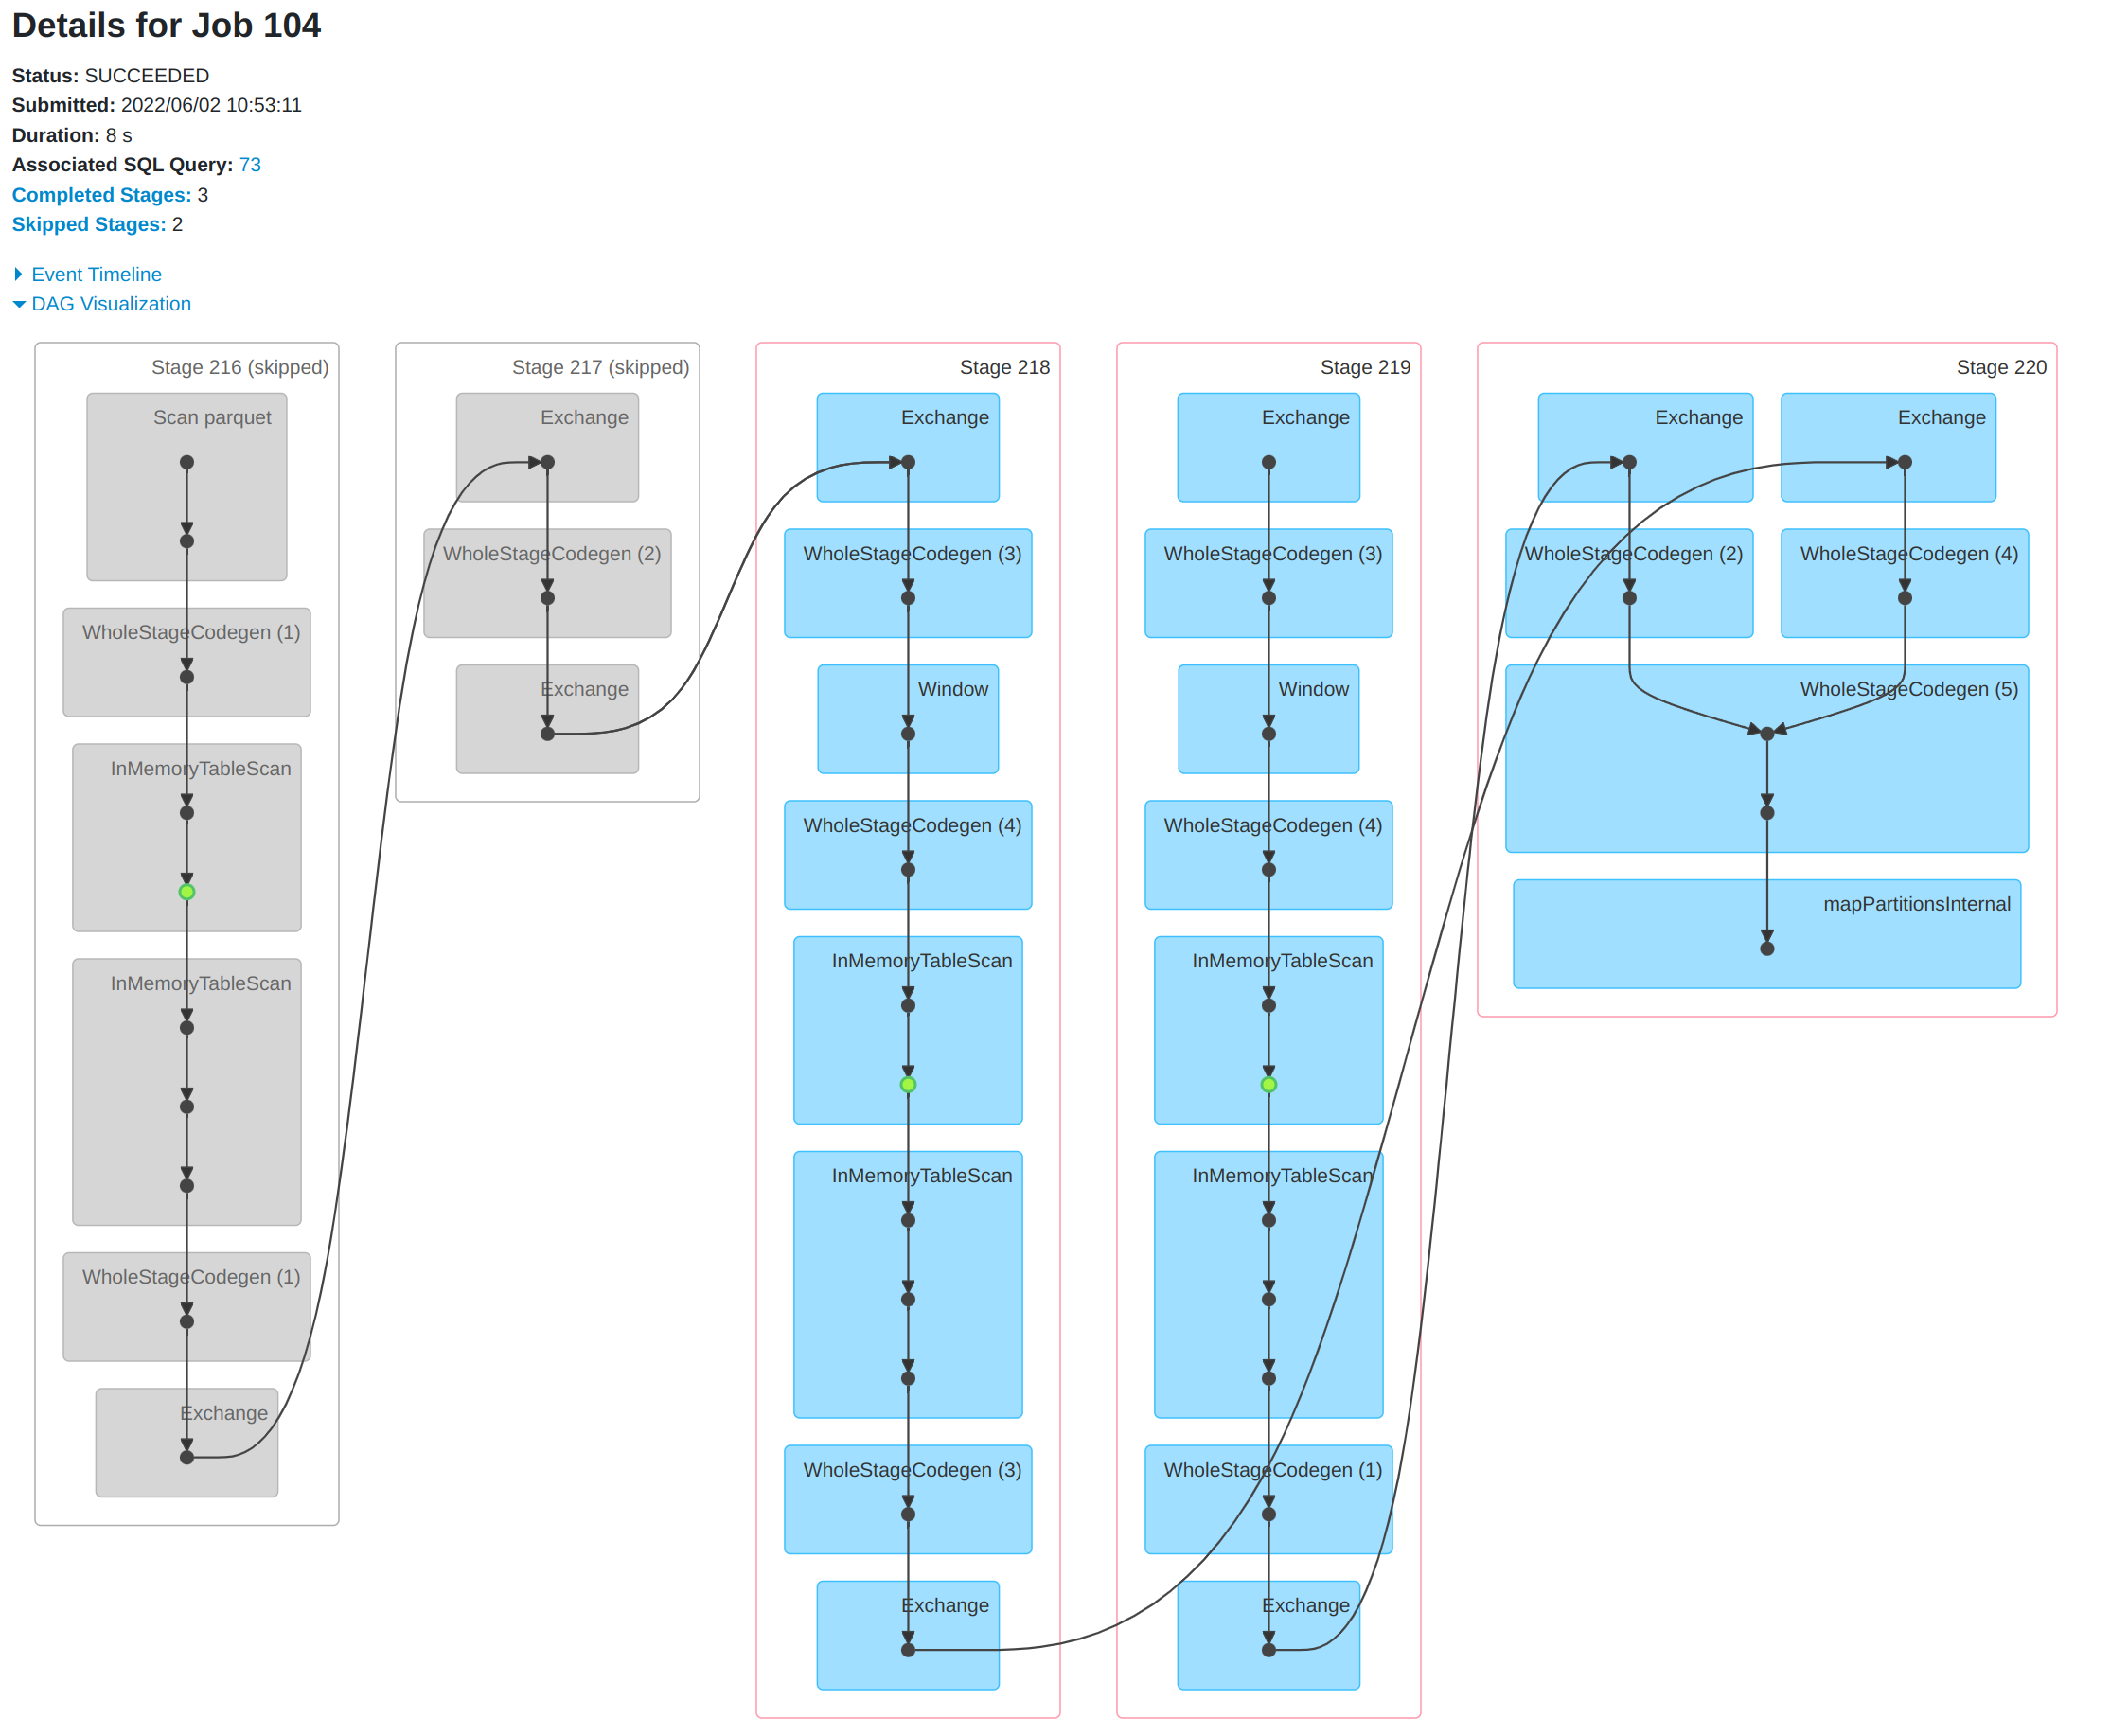
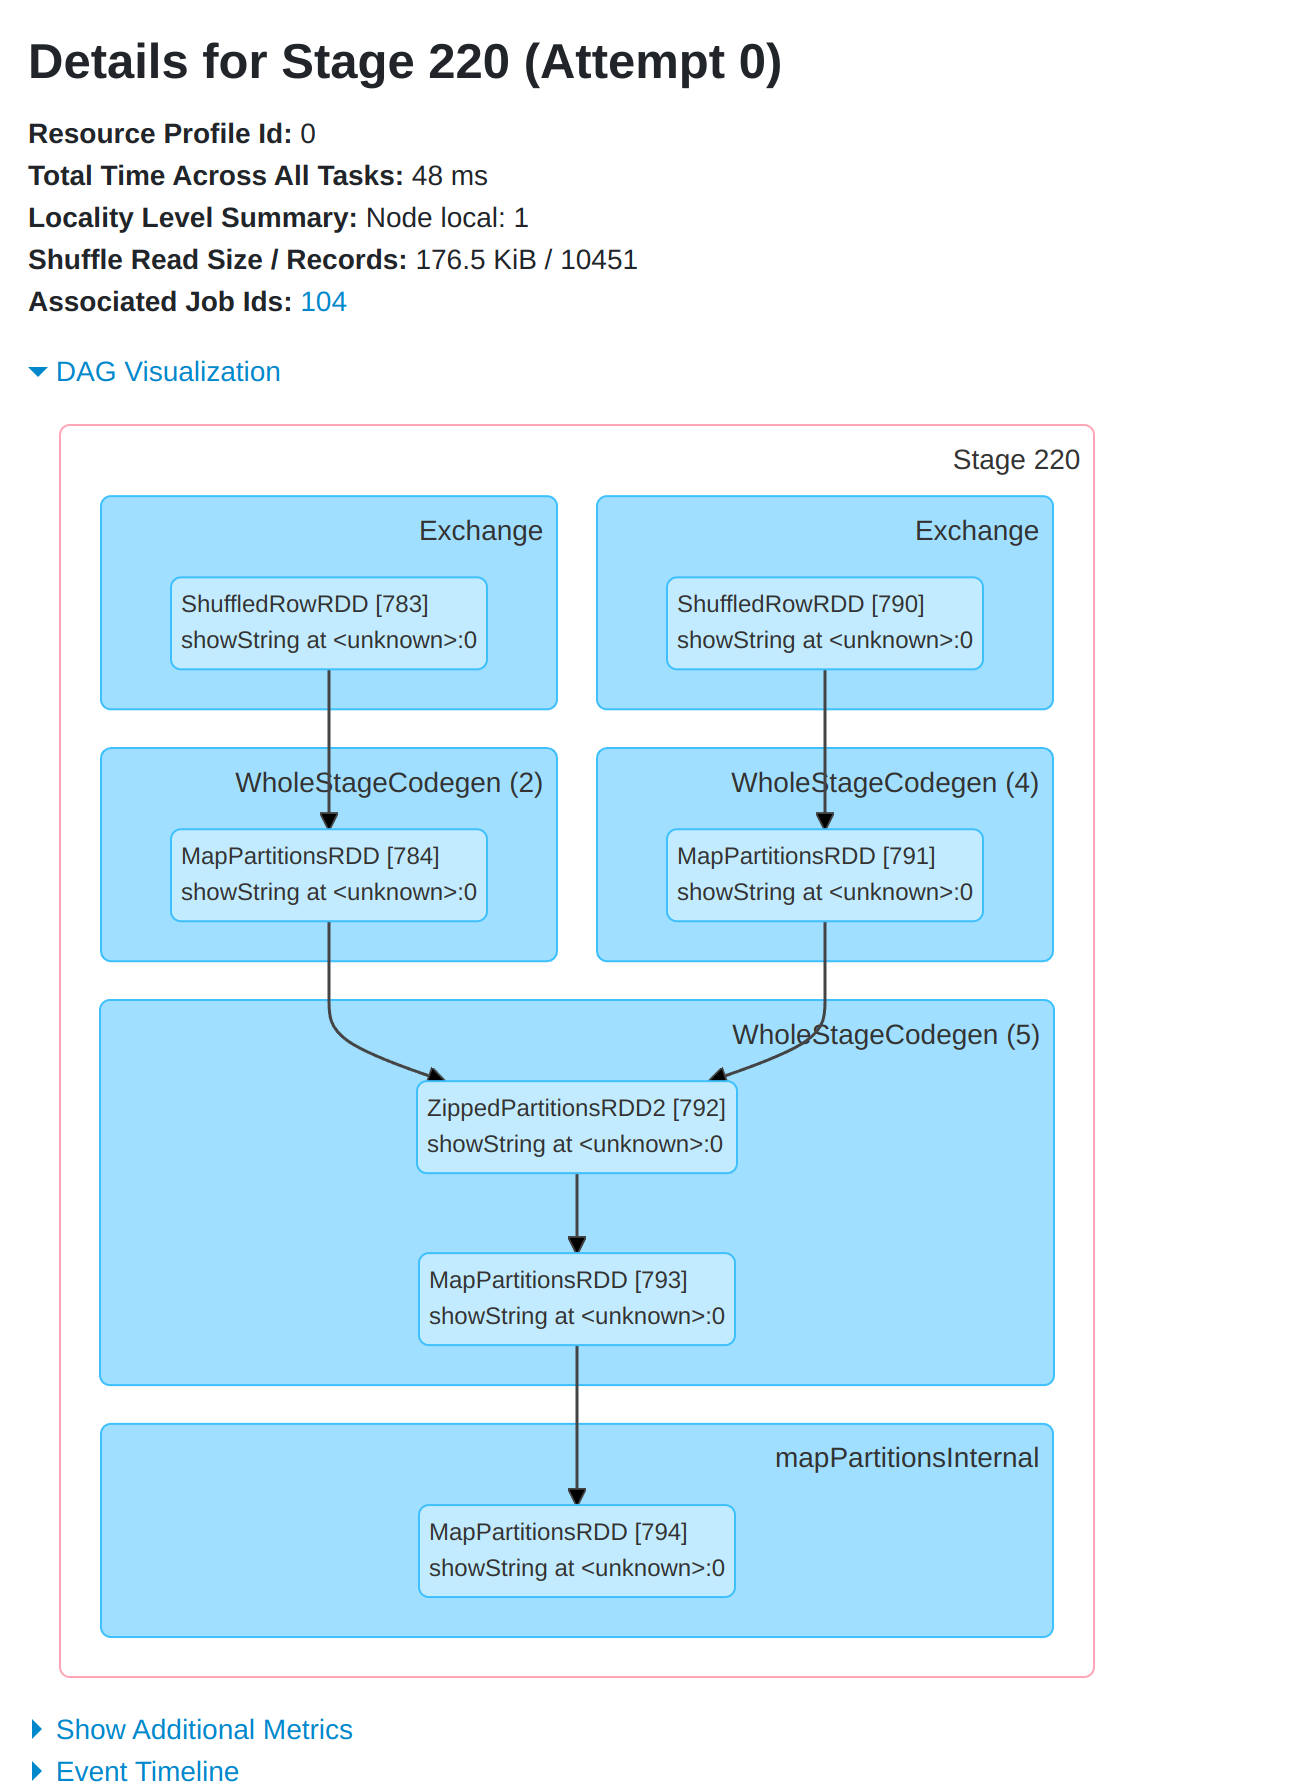

In [105]:
# So it seems it is not possible to avoid SortMergeJoin. But! It's possible to avoid Exchange hashpartitioning!
# Lets do this

In [106]:
task_5.printSchema()

root
 |-- likerId: integer (nullable = true)
 |-- ownerId: integer (nullable = true)
 |-- count: long (nullable = false)
 |-- number: integer (nullable = true)



In [107]:
task_5.show()

+-------+---------+-----+------+
|likerId|  ownerId|count|number|
+-------+---------+-----+------+
|    496| 59139083|    1|     1|
|   2142|  5411213|    5|     1|
|   2142|   152962|    1|     2|
|   3918|145254284|    1|     1|
|   7880|  2812004|    2|     1|
|   9376|   111195|    1|     1|
|  12046|  3824163|    2|     1|
|  13832|    15221|    1|     1|
|  18944|    15221|    1|     1|
|  20135|    75791|    3|     1|
|  20135|174291546|    1|     2|
|  20683|   591512|    1|     1|
|  20924|   327458|    1|     1|
|  23364|131719318|    1|     1|
|  26087|   482756|    1|     1|
|  26623|   216575|    1|     1|
|  28577|   471165|    5|     1|
|  28577|   167177|    2|     2|
|  30654|    55586|    8|     1|
|  32445|   715211|    3|     1|
+-------+---------+-----+------+
only showing top 20 rows



In [121]:
# First of all drop out unnecessery columns
task_7_v1 = task_5.select("ownerId", "likerId").cache()

In [122]:
# Lets preform bucketing 
(task_7_v1
 .write
 .mode("overwrite")
 .format("parquet")
 .bucketBy(2, "ownerId", "likerId")
 .sortBy("ownerId", "likerId")
 .option("path", "hdfs:///tmp/dpogrebnoj-338138/task_7_v1_table_bucketed")
 .saveAsTable("task_7_v1_table_bucketed"))

In [123]:
# Load table
task_7_v1_bucketed = spark.table("task_7_v1_table_bucketed")

In [124]:
# Well, loading finifed correctly
task_7_v1_bucketed.show()

+-------+---------+
|ownerId|  likerId|
+-------+---------+
|    637|  1656812|
|    637|  3931598|
|    637|201245141|
|   1087|    70920|
|   1087|  7098919|
|   1087|294510716|
|   1087|474262195|
|   1087|526708258|
|   1174|   866143|
|   1174|424519612|
|   1174|474262195|
|   3420|   109199|
|   3420| 26342871|
|   3420| 34374673|
|   3420|534315352|
|   3420|548532219|
|   4107|139821585|
|   7373|  3509558|
|   7421|  2880703|
|   8909|167399561|
+-------+---------+
only showing top 20 rows



In [112]:
# Now I replace columns name for proper join
task_7_v2 = task_7_v1.select(F.col("ownerId").alias("likerId"), F.col("likerId").alias("ownerId"))
task_7_v2.show()

+---------+-------+
|  likerId|ownerId|
+---------+-------+
| 59139083|    496|
|  5411213|   2142|
|   152962|   2142|
|145254284|   3918|
|  2812004|   7880|
|   111195|   9376|
|  3824163|  12046|
|    15221|  13832|
|    15221|  18944|
|    75791|  20135|
|174291546|  20135|
|   591512|  20683|
|   327458|  20924|
|131719318|  23364|
|   482756|  26087|
|   216575|  26623|
|   471165|  28577|
|   167177|  28577|
|    55586|  30654|
|   715211|  32445|
+---------+-------+
only showing top 20 rows



In [125]:
# Lets preform bucketing for second table
(task_7_v2
 .write
 .mode("overwrite")
 .format("parquet")
 .bucketBy(2, "ownerId", "likerId")
 .sortBy("ownerId", "likerId")
 .option("path", "hdfs:///tmp/dpogrebnoj-338138/task_7_v2_table_bucketed")
 .saveAsTable("task_7_v2_table_bucketed"))

In [126]:
# Load second table
task_7_v2_bucketed = spark.table("task_7_v2_table_bucketed")

In [127]:
# Loading finished correctly
task_7_v2_bucketed.show()

+---------+-------+
|  likerId|ownerId|
+---------+-------+
|    50601|   2050|
|    75791|   2050|
|  1432788|   2050|
| 14504777|   2050|
|242670751|   2050|
|     1669|  14677|
| 38160061|  25339|
|     5648|  34013|
| 48110787|  34013|
|   640248|  42521|
| 16861388|  60552|
|  1585877|  74524|
|  5411213|  76358|
| 11060830|  77139|
|  1658552|  77440|
|264743483|  82768|
|   246481|  86363|
| 11938274|  90767|
|   109961|  92352|
| 25788845| 101485|
+---------+-------+
only showing top 20 rows



In [128]:
# Now we should have two tables with same number of buckets on the same columns.
# In this case spark no need to perform Exchange hashpartitioning

In [129]:
spark.sql("DESCRIBE EXTENDED task_7_v1_table_bucketed").show()

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|             ownerId|                 int|   null|
|             likerId|                 int|   null|
|                    |                    |       |
|# Detailed Table ...|                    |       |
|            Database|             default|       |
|               Table|task_7_v1_table_b...|       |
|        Created Time|Thu Jun 02 10:57:...|       |
|         Last Access|             UNKNOWN|       |
|          Created By|         Spark 3.1.1|       |
|                Type|            EXTERNAL|       |
|            Provider|             parquet|       |
|         Num Buckets|                   2|       |
|      Bucket Columns|[`ownerId`, `like...|       |
|        Sort Columns|[`ownerId`, `like...|       |
|            Location|hdfs:///tmp/dpogr...|       |
+--------------------+--------------------+-------+



In [130]:
spark.sql("DESCRIBE EXTENDED task_7_v2_table_bucketed").show()

+--------------------+--------------------+-------+
|            col_name|           data_type|comment|
+--------------------+--------------------+-------+
|             likerId|                 int|   null|
|             ownerId|                 int|   null|
|                    |                    |       |
|# Detailed Table ...|                    |       |
|            Database|             default|       |
|               Table|task_7_v2_table_b...|       |
|        Created Time|Thu Jun 02 10:58:...|       |
|         Last Access|             UNKNOWN|       |
|          Created By|         Spark 3.1.1|       |
|                Type|            EXTERNAL|       |
|            Provider|             parquet|       |
|         Num Buckets|                   2|       |
|      Bucket Columns|[`ownerId`, `like...|       |
|        Sort Columns|[`ownerId`, `like...|       |
|            Location|hdfs:///tmp/dpogr...|       |
+--------------------+--------------------+-------+



In [131]:
# Finally! Lets check that now there is no Exchange hashpartitioning during joining execution
(task_7_v1_bucketed
 .join(task_7_v2_bucketed, ["ownerId", "likerId"])
        .select(F.col("task_7_v1_table_bucketed.ownerId").alias("friendId1"), 
                F.col("task_7_v1_table_bucketed.likerId").alias("friendId2"))).explain()

== Physical Plan ==
*(3) Project [ownerId#18969 AS friendId1#19103, likerId#18970 AS friendId2#19104]
+- *(3) SortMergeJoin [ownerId#18969, likerId#18970], [ownerId#19027, likerId#19026], Inner
   :- *(1) Sort [ownerId#18969 ASC NULLS FIRST, likerId#18970 ASC NULLS FIRST], false, 0
   :  +- *(1) Filter (isnotnull(ownerId#18969) AND isnotnull(likerId#18970))
   :     +- *(1) ColumnarToRow
   :        +- FileScan parquet default.task_7_v1_table_bucketed[ownerId#18969,likerId#18970] Batched: true, DataFilters: [isnotnull(ownerId#18969), isnotnull(likerId#18970)], Format: Parquet, Location: InMemoryFileIndex[hdfs://hdfs-namenode-0.hdfs-namenode.hdfs.svc.cluster.local:8020/tmp/dpogrebnoj..., PartitionFilters: [], PushedFilters: [IsNotNull(ownerId), IsNotNull(likerId)], ReadSchema: struct<ownerId:int,likerId:int>, SelectedBucketsCount: 2 out of 2
   +- *(2) Sort [ownerId#19027 ASC NULLS FIRST, likerId#19026 ASC NULLS FIRST], false, 0
      +- *(2) Filter (isnotnull(ownerId#19027) AND isnotnu

In [132]:
(task_7_v1_bucketed
 .join(task_7_v2_bucketed, ["ownerId", "likerId"])
        .select(F.col("task_7_v1_table_bucketed.ownerId").alias("friendId1"), 
                F.col("task_7_v1_table_bucketed.likerId").alias("friendId2"))).show()

+---------+---------+
|friendId1|friendId2|
+---------+---------+
|      637|    94494|
|      637| 25381537|
|     1119|  2004962|
|     1127|    27857|
|     1174|  2134327|
|     1174|139499389|
|     1567|      637|
|     1567|    94494|
|     2212|     1567|
|     4023|  1548876|
|     4023| 10349204|
|     4023|118984095|
|     4023|142992667|
|     7373|218091600|
|     8909| 12742533|
|    12671|    12977|
|    12671|   369330|
|    12671|   484523|
|    12977|   269559|
|    12977|   308368|
+---------+---------+
only showing top 20 rows



### Result screenshots - task with only one stage and stage in more ditails
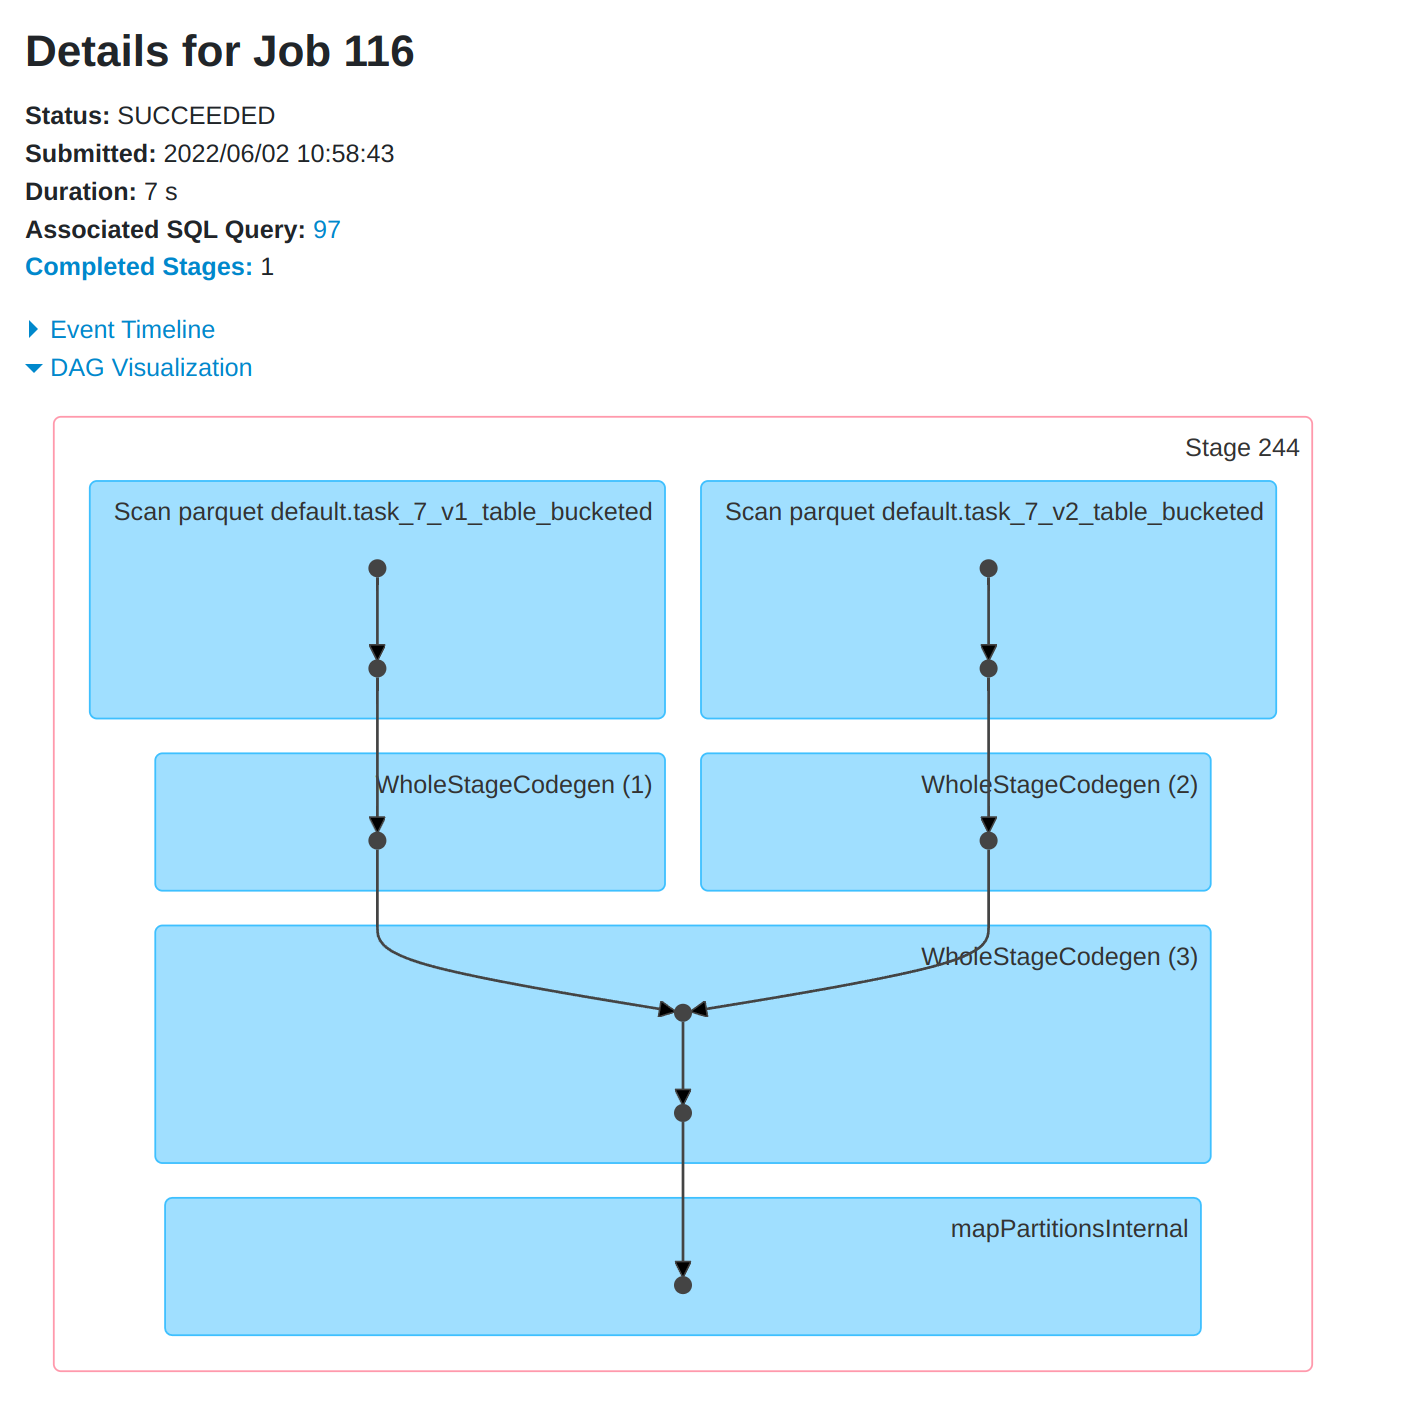
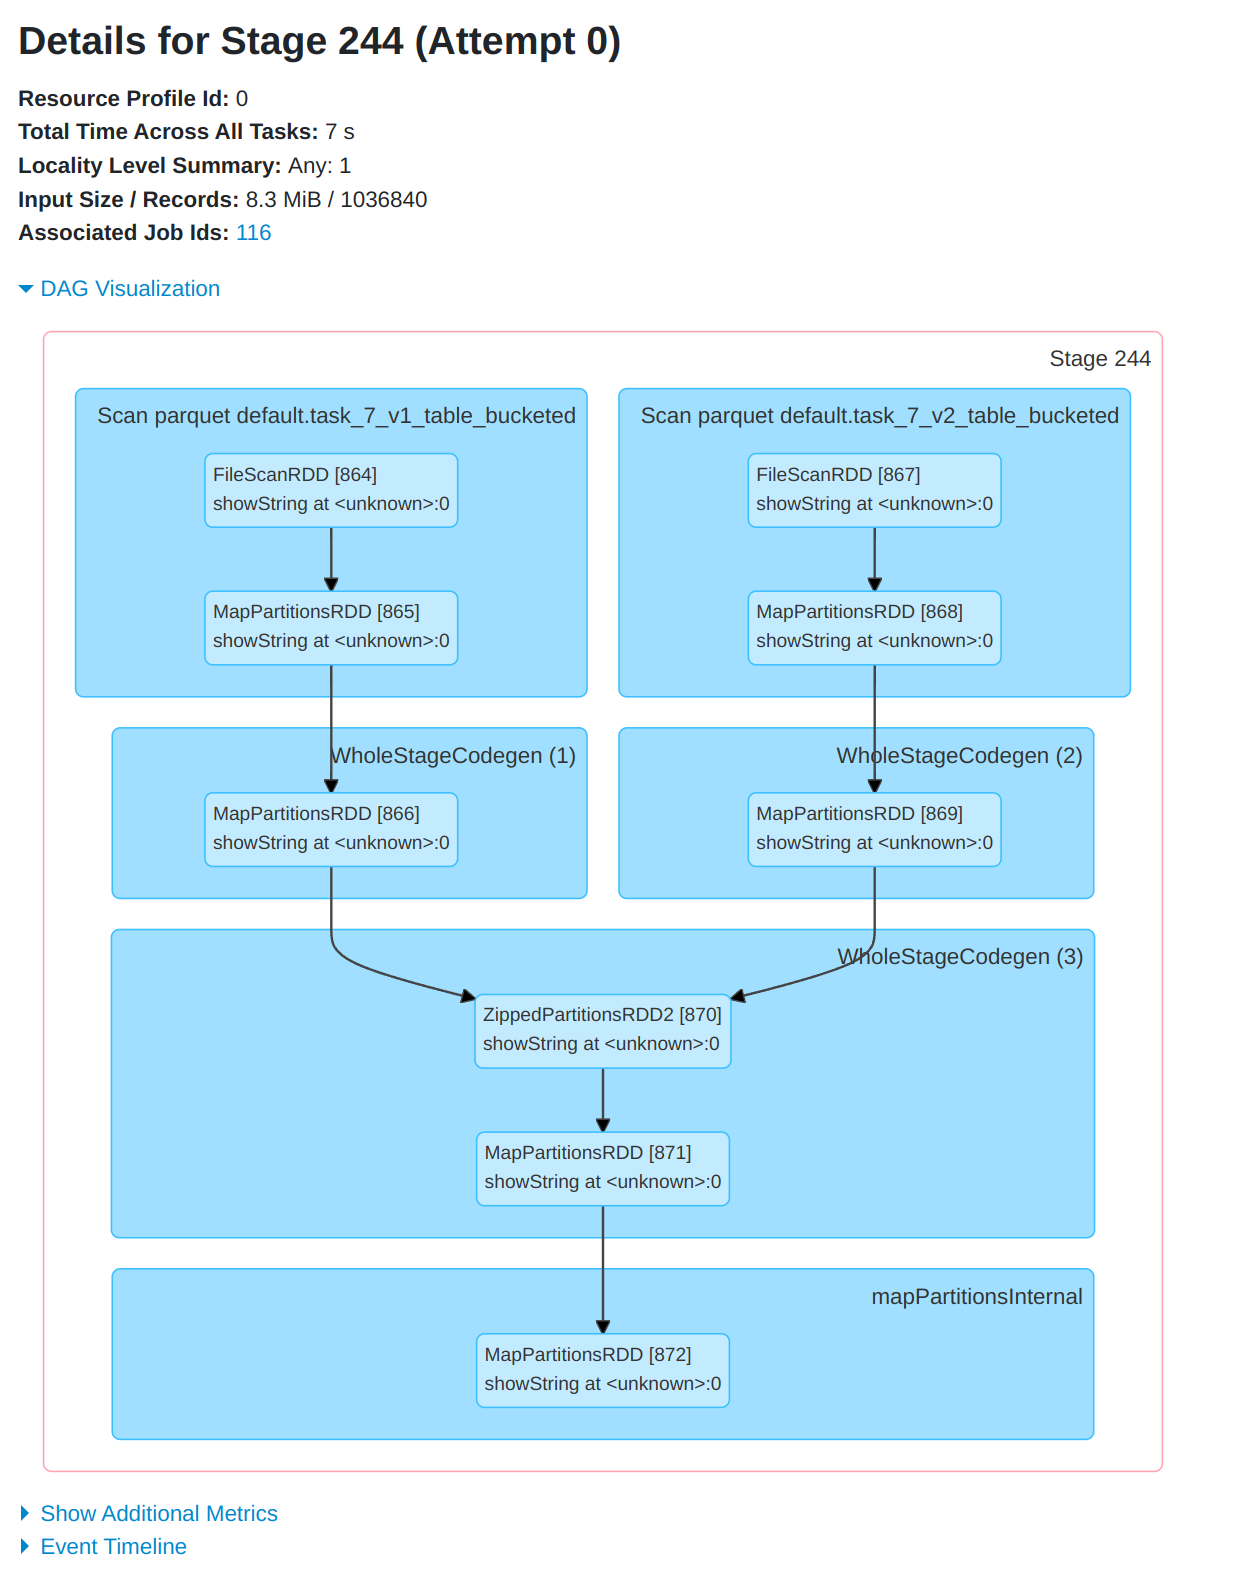

In [70]:
#! hdfs dfs -rmr "hdfs:///tmp/dpogrebnoj-338138/task_5_v2_bucketed"

In [133]:
spark.stop()